
# Tutorial 7: **Intrinsically Interpretable Models** — Evaluations & CIs

You will fit and interpret **L2-Logistic**, a **depth-limited Decision Tree**, **KNN Classifier** and an **EBM**.  
We include **evaluation metrics** and **95% bootstrap confidence intervals (CIs)** for each model.  


## 0) Setup & data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss

RANDOM_STATE = 42

# Try to load your dataset
data_path = Path('./Features/features_df_10s_3s.csv')


df = pd.read_csv(data_path)
target_col = 'activity' if 'activity' in df.columns else 'target'


numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols: numeric_cols.remove(target_col)
X = df[numeric_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE,
    stratify=y if len(np.unique(y))<=10 else None
)
print('Train:', X_train.shape, ' Test:', X_test.shape)
print(X_train.head())


Train: (6722, 61)  Test: (1681, 61)
      window  acc_x_mean  acc_x_std  acc_x_ptp  acc_x_skew  acc_x_kurtosis  \
2390      33   -0.008512   0.006249   0.041967    0.149924        0.546546   
3615      20    0.067163   0.284848   1.610670    0.501778        0.256538   
6805      11    0.201750   0.307975   1.699068    0.531265        0.577609   
3233       7    0.537167   0.294251   2.013739    0.638054        1.284578   
3410      44    0.589690   0.010666   0.075772   -0.916519        2.549984   

      acc_x_max  acc_x_min  acc_x_rms  acc_x_dom_freq  ...  gyro_z_mean  \
2390   0.012050  -0.029917   0.010560             0.6  ...     0.003046   
3615   0.917291  -0.693378   0.292659             5.8  ...    -0.111466   
6805   1.243840  -0.455228   0.368173             3.6  ...     0.064606   
3233   1.687501  -0.326238   0.612480             1.0  ...    -0.021329   
3410   0.625405   0.549633   0.589786             0.2  ...     0.010949   

      gyro_z_std  gyro_z_ptp  gyro_z_skew  g

### Helper: reliability diagram & ECE

In [10]:

def reliability_ece(y_true, proba, n_bins=15, classes=None, y_pred=None, binning='equal_width'):
    """
    Top-label reliability diagram + ECE.
    - y_true: array of true labels (strings or ints)
    - proba:  (n_samples, n_classes)
    - classes: optional array of class labels matching proba columns (e.g., model.classes_)
    - y_pred: optional array of predicted labels (same dtype as y_true). If provided, we use it.
    - binning: 'equal_width' or 'equal_freq'
    """
    import numpy as np
    import matplotlib.pyplot as plt

    y_true = np.asarray(y_true)
    conf = proba.max(axis=1)

    if y_pred is None:
        idx = proba.argmax(axis=1)
        if classes is not None:
            y_pred = np.asarray(classes)[idx]     # map to label dtype
        else:
            y_pred = idx                          # only safe if y_true are ints 0..K-1
    else:
        y_pred = np.asarray(y_pred)

    correct = (y_pred == y_true).astype(int)

    # binning
    if binning == 'equal_freq':
        qs = np.linspace(0, 1, n_bins+1)
        edges = np.quantile(conf, qs)
        edges[0], edges[-1] = 0.0, 1.0
        idx_bin = np.searchsorted(edges, conf, side='right') - 1
    else:
        edges = np.linspace(0, 1, n_bins+1)
        idx_bin = np.digitize(conf, edges) - 1

    ece, xs, ys = 0.0, [], []
    for b in range(n_bins):
        m = (idx_bin == b)
        if m.sum() == 0:
            continue
        acc_b = correct[m].mean()
        conf_b = conf[m].mean()
        ece += (m.sum() / len(y_true)) * abs(acc_b - conf_b)
        xs.append(conf_b); ys.append(acc_b)

    plt.figure()
    plt.plot([0, 1], [0, 1], '--')
    plt.plot(xs, ys, marker='o')
    plt.xlabel('Mean confidence (per bin)')
    plt.ylabel('Empirical accuracy (per bin)')
    plt.title(f'Reliability diagram (ECE={ece:.4f})')
    plt.show()
    return float(ece)



### Helper: metric evaluation & bootstrap confidence intervals

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

def _bin_indices(conf, n_bins=50, binning='equal_freq'):
    """Return per-sample bin index for confidence values."""
    conf = np.asarray(conf, dtype=float)
    if binning == 'equal_freq':
        qs = np.linspace(0, 1, n_bins + 1)
        edges = np.quantile(conf, qs)
        edges[0], edges[-1] = 0.0, 1.0
        # If many duplicates (e.g., confidences all the same), fall back to equal-width
        if np.unique(edges).size < edges.size:
            edges = np.linspace(0, 1, n_bins + 1)
        idx = np.searchsorted(edges, conf, side='right') - 1
    else:  # 'equal_width'
        edges = np.linspace(0, 1, n_bins + 1)
        idx = np.digitize(conf, edges) - 1
    # keep in range [0, n_bins-1]
    idx = np.clip(idx, 0, n_bins - 1)
    return idx, n_bins

def ece_only(y_true, proba, n_bins=50, *, classes=None, y_pred=None, binning='equal_freq'):
    """
    Top-label ECE with robust label handling and flexible binning.
    - y_true: array of true labels (strings or ints)
    - proba : (n_samples, n_classes) predicted probabilities
    - classes: optional sequence matching proba columns (e.g., model.classes_)
    - y_pred: optional predicted labels (same dtype as y_true). If not given,
              we map argmax indices to labels via `classes` when provided.
    - binning: 'equal_freq' (default) or 'equal_width'
    """
    y_true = np.asarray(y_true)
    conf = proba.max(axis=1)

    if y_pred is None:
        top_idx = proba.argmax(axis=1)
        y_pred = (np.asarray(classes)[top_idx] if classes is not None else top_idx)
    else:
        y_pred = np.asarray(y_pred)

    correct = (y_pred == y_true).astype(int)
    idx, B = _bin_indices(conf, n_bins=n_bins, binning=binning)

    ece = 0.0
    for b in range(B):
        m = (idx == b)
        if m.sum() == 0:
            continue
        acc_b  = correct[m].mean()
        conf_b = conf[m].mean()
        ece += (m.sum() / len(y_true)) * abs(acc_b - conf_b)
    return float(ece)

def classwise_ece(y_true, proba, classes, n_bins=50, binning='equal_freq'):
    """
    Compute classwise ECE (OvR) and macro average.
    y_true : array-like of true labels (strings or ints)
    proba  : (n_samples, n_classes) predicted probabilities
    classes: sequence of class labels matching proba columns (e.g., model.classes_)
    """
    y_true = np.asarray(y_true)
    classes = np.asarray(classes)
    K = proba.shape[1]
    rows = []
    eces = []

    for k in range(K):
        p_k = proba[:, k]
        pos = (y_true == classes[k]).astype(int)   # one-vs-rest ground truth
        idx, B = _bin_indices(p_k, n_bins=n_bins, binning=binning)

        ece_k = 0.0
        for b in range(B):
            m = (idx == b)
            if m.sum() == 0:
                continue
            acc_b  = pos[m].mean()
            conf_b = p_k[m].mean()
            ece_k += (m.sum() / len(y_true)) * abs(acc_b - conf_b)

        eces.append(ece_k)
        rows.append({
            'class': classes[k],
            'ece': float(ece_k),
            'prevalence': float(pos.mean()),
        })

    macro_ece = float(np.mean(eces))
    table = pd.DataFrame(rows).sort_values('ece', ascending=False).reset_index(drop=True)
    return macro_ece, table

def plot_ece_bar(ece_table, title='Classwise ECE'):
    plt.figure()
    labels = [str(c) for c in ece_table['class']]
    plt.bar(labels, ece_table['ece'].values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('ECE')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_classwise_reliability(y_true, proba, classes, class_subset=None, n_bins=10, binning='equal_freq'):
    """
    Plot one reliability diagram per class (OvR). By default shows all classes;
    pass class_subset (list of labels) to limit to e.g. the worst 6 by ECE.
    """
    y_true = np.asarray(y_true)
    classes = np.asarray(classes)
    if class_subset is None:
        class_subset = classes

    for c in class_subset:
        k = list(classes).index(c)
        p_k = proba[:, k]
        pos = (y_true == classes[k]).astype(int)

        idx, B = _bin_indices(p_k, n_bins=n_bins, binning=binning)
        xs, ys = [], []
        ece = 0.0
        for b in range(B):
            m = (idx == b)
            if m.sum() == 0:
                continue
            acc_b  = pos[m].mean()
            conf_b = p_k[m].mean()
            ece += (m.sum()/len(y_true)) * abs(acc_b - conf_b)
            xs.append(conf_b); ys.append(acc_b)

        plt.figure()
        plt.plot([0,1],[0,1],'--')
        plt.plot(xs, ys, marker='o')
        plt.xlabel('Mean confidence for class "{}"'.format(c))
        plt.ylabel('Empirical accuracy (is_y==class)')
        plt.title('Classwise reliability — {} (ECE={:.4f})'.format(c, ece))
        plt.show()

def compute_metrics(y_true, proba, preds, *, average='binary', labels=None, binning='equal_freq'):
    """
    Metrics with safe NLL label alignment and robust ECE.
    - labels: pass model.classes_ in multiclass to align log_loss columns
    - binning: forwarded to ece_only
    """
    y_true = np.asarray(y_true)
    preds  = np.asarray(preds)
    acc = accuracy_score(y_true, preds)
    f1  = f1_score(y_true, preds, average=average)
    try:
        nll = log_loss(y_true, proba, labels=labels)
    except Exception:
        nll = np.nan
    # Use preds directly to avoid dtype mismatches inside ECE
    ece = ece_only(y_true, proba, n_bins=50, classes=labels, y_pred=preds, binning=binning)
    return {'accuracy': acc, 'f1': f1, 'nll': float(nll), 'ece': ece}

def bootstrap_ci(y_true, proba, preds, *, average='binary', labels=None, B=300, seed=42, binning='equal_freq'):
    """
    Bootstrap CIs for Accuracy, F1, NLL, ECE.
    - labels: pass model.classes_ when available (multiclass)
    - binning: forwarded to ece_only
    """
    rng = np.random.RandomState(seed)
    y_true = np.asarray(y_true); n = len(y_true)
    accs, f1s, nlls, eces = [], [], [], []
    for _ in range(B):
        idx = rng.randint(0, n, size=n)
        m = compute_metrics(y_true[idx], proba[idx], preds[idx],
                            average=average, labels=labels, binning=binning)
        accs.append(m['accuracy']); f1s.append(m['f1'])
        nlls.append(m['nll']);      eces.append(m['ece'])
    df = pd.DataFrame({'accuracy': accs, 'f1': f1s, 'nll': nlls, 'ece': eces})
    return df.describe(percentiles=[0.025, 0.5, 0.975]).T[['mean', 'std', '2.5%', '50%', '97.5%']]


## A) L2-Logistic — sparsity + calibration 

c:\Users\liyan\anaconda3\envs\learning\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Multinomial Logistic (L2, lbfgs) metrics: {'accuracy': 0.9928613920285544, 'f1': 0.9879883593032336, 'nll': 0.02936612596060854, 'ece': 0.008854548455014034}


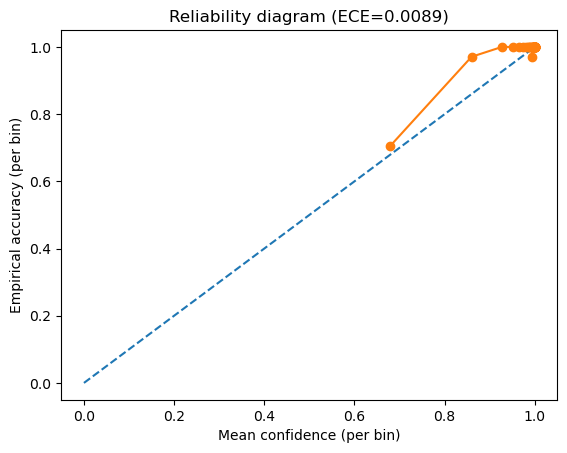

In [45]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(X_train)
Xte_s = scaler.transform(X_test)

logreg = LogisticRegression(
    penalty='l2', solver='lbfgs',
    multi_class='multinomial', max_iter=2000, n_jobs=-1, C=1.0, random_state=42
)
logreg.fit(Xtr_s, y_train)

proba_lr = logreg.predict_proba(Xte_s)
pred_lr  = logreg.predict(Xte_s)

# Metrics (robust to helper signature)
avg = 'binary' if len(np.unique(y)) <= 2 else 'macro'
try:
    # Preferred: your helper supports labels=
    m_lr = compute_metrics(y_test.to_numpy(), proba_lr, pred_lr,
                           average=avg, labels=logreg.classes_)
except TypeError:
    # Fallback: helper without labels=; patch NLL afterward
    m_lr = compute_metrics(y_test.to_numpy(), proba_lr, pred_lr, average=avg)
    try:
        m_lr['nll'] = float(log_loss(y_test, proba_lr, labels=logreg.classes_))
    except Exception:
        pass

print("Multinomial Logistic (L2, lbfgs) metrics:", m_lr)

# Reliability / ECE (top-label)
ece_lr = reliability_ece(
    y_test.to_numpy(),
    proba_lr,
    classes=logreg.classes_,   # maps argmax to labels if y_pred not given
    y_pred=pred_lr,            # safest: pass the labels directly
    n_bins=50,
    binning='equal_freq'       # nicer, more stable binning
)


Global feature importance (L2 norm across class-wise coefficients):


,L2_norm
acc_z_std,4.557227
acc_z_rms,3.650003
acc_z_mean,3.043351
acc_y_dom_power,2.975812
acc_z_kurtosis,2.814457
acc_y_rms,2.599318
acc_x_kurtosis,2.544038
gyro_y_rms,2.430367
acc_x_dom_power,2.255133
acc_y_std,2.177237



Top 10 features per class (by |β|):


,coef,abs_coef,class_
acc_y_dom_power,-1.841932,1.841932,downstairs
acc_z_dom_power,-1.754478,1.754478,downstairs
gyro_y_rms,1.445168,1.445168,downstairs
acc_z_kurtosis,-1.346309,1.346309,downstairs
acc_z_skew,1.346226,1.346226,downstairs
acc_y_skew,1.165265,1.165265,downstairs
gyro_y_std,1.102275,1.102275,downstairs
gyro_z_dom_power,-1.009330,1.009330,downstairs
acc_x_min,-0.996500,0.996500,downstairs
gyro_y_skew,-0.859976,0.859976,downstairs


,coef,abs_coef,class_
acc_y_dom_power,2.198200,2.198200,jogging
acc_y_std,1.845429,1.845429,jogging
acc_x_dom_power,1.158537,1.158537,jogging
acc_y_ptp,1.056517,1.056517,jogging
gyro_x_dom_freq,1.050334,1.050334,jogging
acc_y_max,1.037178,1.037178,jogging
acc_y_rms,0.929289,0.929289,jogging
acc_z_dom_power,0.895224,0.895224,jogging
acc_y_min,-0.834566,0.834566,jogging
gyro_y_dom_power,0.716293,0.716293,jogging


,coef,abs_coef,class_
acc_z_rms,2.456821,2.456821,sitting
acc_y_rms,-1.436205,1.436205,sitting
acc_x_rms,1.072176,1.072176,sitting
acc_z_kurtosis,0.770212,0.770212,sitting
acc_z_max,-0.751571,0.751571,sitting
acc_z_mean,-0.738411,0.738411,sitting
acc_x_kurtosis,0.686759,0.686759,sitting
acc_y_mean,-0.590717,0.590717,sitting
gyro_z_kurtosis,0.527302,0.527302,sitting
gyro_x_kurtosis,0.516643,0.516643,sitting


,coef,abs_coef,class_
acc_z_rms,-2.156863,2.156863,standing
acc_y_rms,0.932526,0.932526,standing
acc_z_min,0.893105,0.893105,standing
acc_y_min,0.787658,0.787658,standing
acc_z_mean,0.766214,0.766214,standing
acc_x_rms,-0.755750,0.755750,standing
acc_x_kurtosis,0.719142,0.719142,standing
acc_y_kurtosis,0.702982,0.702982,standing
acc_y_std,-0.653619,0.653619,standing
acc_y_ptp,-0.649242,0.649242,standing


,coef,abs_coef,class_
acc_z_std,-2.391115,2.391115,upstairs
acc_x_kurtosis,-2.181980,2.181980,upstairs
acc_z_mean,-1.862129,1.862129,upstairs
acc_x_dom_power,-1.743901,1.743901,upstairs
gyro_y_skew,1.520199,1.520199,upstairs
acc_z_min,-1.484428,1.484428,upstairs
acc_z_ptp,1.348737,1.348737,upstairs
gyro_y_mean,1.191029,1.191029,upstairs
acc_z_kurtosis,-1.123439,1.123439,upstairs
gyro_y_rms,1.114992,1.114992,upstairs


,coef,abs_coef,class_
acc_z_std,3.784397,3.784397,walking
acc_z_mean,2.086389,2.086389,walking
acc_z_kurtosis,1.869037,1.869037,walking
gyro_y_kurtosis,-1.489497,1.489497,walking
gyro_y_rms,-1.474760,1.474760,walking
acc_z_rms,-1.429628,1.429628,walking
gyro_z_kurtosis,-1.257612,1.257612,walking
acc_y_rms,1.227440,1.227440,walking
acc_z_skew,-1.168447,1.168447,walking
acc_y_skew,-1.127185,1.127185,walking


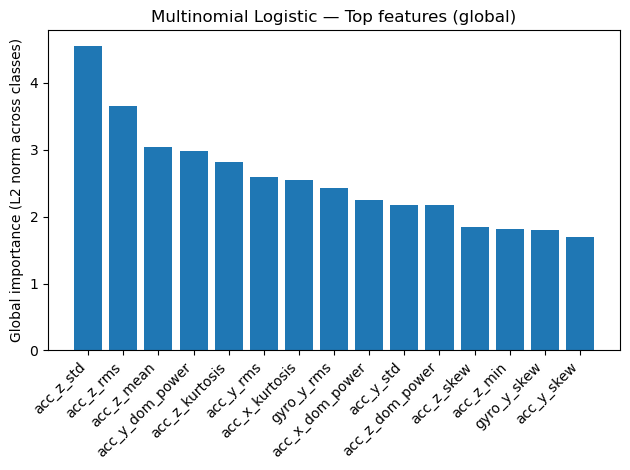


Pairwise odds multipliers vs baseline class = 'downstairs' (exp(β_c - β_baseline)) for top 5 global features:


,acc_z_std,acc_z_rms,acc_z_mean,acc_y_dom_power,acc_z_kurtosis
downstairs,1.000,1.000,1.000,1.000,1.000
jogging,1.964,1.398,0.475,56.834,1.917
sitting,1.208,8.274,0.374,5.743,8.302
standing,1.279,0.082,1.682,6.106,6.502
upstairs,0.171,0.789,0.121,3.261,1.250
walking,82.306,0.170,6.297,9.701,24.912


In [46]:
n_classes = len(logreg.classes_)

# Make sure feature names match the fitted dimension
feature_names = list(numeric_cols)
n_feat = logreg.coef_.shape[1]
if len(feature_names) != n_feat:
    feature_names = [f"f{i}" for i in range(n_feat)]

if n_classes == 2:
    # Binary logistic: standard odds interpretation is valid
    beta = pd.Series(logreg.coef_.ravel(), index=feature_names)
    odds = np.exp(beta)  # multiplicative change in odds of class=classes_[1] per +1 (standardized) unit

    tbl = (pd.DataFrame({
            'coef': beta,
            'odds_ratio (class={} vs {})'.format(logreg.classes_[1], logreg.classes_[0]): odds
        })
        .sort_values('coef', key=lambda s: s.abs(), ascending=False))

    display(tbl.head(15))

    plt.figure()
    plt.bar(tbl.head(15).index.astype(str), tbl.head(15)['coef'].values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Coefficient (β)  — binary logistic')
    plt.title('Top coefficients (by |β|) — Logistic (binary, L2)')
    plt.tight_layout()
    plt.show()

else:
    # Multinomial (softmax) logistic: coef_ is K x p.
    # A safe global importance is the L2 norm across classes for each feature.
    coef_mat = pd.DataFrame(logreg.coef_, index=logreg.classes_, columns=feature_names)

    global_imp = pd.Series(
        np.linalg.norm(coef_mat.values, axis=0), index=feature_names
    ).sort_values(ascending=False)

    print("Global feature importance (L2 norm across class-wise coefficients):")
    display(global_imp.head(15).to_frame('L2_norm'))

    # Per-class top features
    top_k = 10
    print(f"\nTop {top_k} features per class (by |β|):")
    for cls in coef_mat.index:
        s = coef_mat.loc[cls].abs().sort_values(ascending=False).head(top_k)
        out = pd.DataFrame({
            'coef': coef_mat.loc[cls, s.index],
            'abs_coef': s
        }).assign(class_=cls)
        display(out)

    # Bar plot of global top features
    top = global_imp.head(15)
    plt.figure()
    plt.bar(top.index.astype(str), top.values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Global importance (L2 norm across classes)')
    plt.title('Multinomial Logistic — Top features (global)')
    plt.tight_layout()
    plt.show()

    # Optional: pairwise odds-style view relative to a baseline class.
    # For multinomial, log-odds between class c and baseline b for feature j is (β_cj - β_bj).
    # Exponentiating gives multiplicative change in odds (c vs b) per +1 standardized unit.
    baseline = logreg.classes_[0]
    rel_odds = np.exp(coef_mat.sub(coef_mat.loc[baseline], axis=1))  # shape K x p
    print(f"\nPairwise odds multipliers vs baseline class = '{baseline}' (exp(β_c - β_baseline)) "
          f"for top 5 global features:")
    display(rel_odds[top.index[:5]].round(3))

In [47]:
# 95% bootstrap CIs
ci_lr = bootstrap_ci(y_test.to_numpy(), proba_lr, pred_lr,
                     average=avg, labels=logreg.classes_, B=300, seed=42, binning='equal_freq')
display(ci_lr)

,mean,std,2.5%,50%,97.5%
accuracy,0.993050,0.002050,0.988980,0.992861,0.996743
f1,0.988223,0.003514,0.981230,0.988345,0.994756
nll,0.028969,0.005472,0.019627,0.028748,0.041259
ece,0.009877,0.001537,0.007068,0.009816,0.013023


## B) Decision Tree

In [49]:

tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=RANDOM_STATE)
tree.fit(X_train, y_train)

proba_tr = tree.predict_proba(X_test)
pred_tr  = tree.predict(X_test)

avg = 'binary' if len(np.unique(y))<=2 else 'macro'
m_tr = compute_metrics(y_test.to_numpy(), proba_tr, pred_tr, average=avg)
print("Decision Tree metrics:", m_tr)

# Readable text rules (no Graphviz dependency)
text_rules = export_text(tree, feature_names=list(numeric_cols))
print(text_rules)


Decision Tree metrics: {'accuracy': 0.983343248066627, 'f1': 0.9767519592561918, 'nll': 0.10279028941286589, 'ece': 0.001725015165086553}
|--- acc_y_max <= 0.91
|   |--- acc_z_rms <= 0.34
|   |   |--- acc_y_ptp <= 0.72
|   |   |   |--- class: standing
|   |   |--- acc_y_ptp >  0.72
|   |   |   |--- acc_y_mean <= -0.97
|   |   |   |   |--- class: walking
|   |   |   |--- acc_y_mean >  -0.97
|   |   |   |   |--- class: downstairs
|   |--- acc_z_rms >  0.34
|   |   |--- gyro_y_ptp <= 6.61
|   |   |   |--- acc_z_rms <= 0.37
|   |   |   |   |--- gyro_y_dom_freq <= 1.15
|   |   |   |   |   |--- class: standing
|   |   |   |   |--- gyro_y_dom_freq >  1.15
|   |   |   |   |   |--- class: sitting
|   |   |   |--- acc_z_rms >  0.37
|   |   |   |   |--- class: sitting
|   |   |--- gyro_y_ptp >  6.61
|   |   |   |--- class: upstairs
|--- acc_y_max >  0.91
|   |--- acc_y_ptp <= 0.67
|   |   |--- acc_z_mean <= -0.41
|   |   |   |--- class: sitting
|   |   |--- acc_z_mean >  -0.41
|   |   |   |--- cl

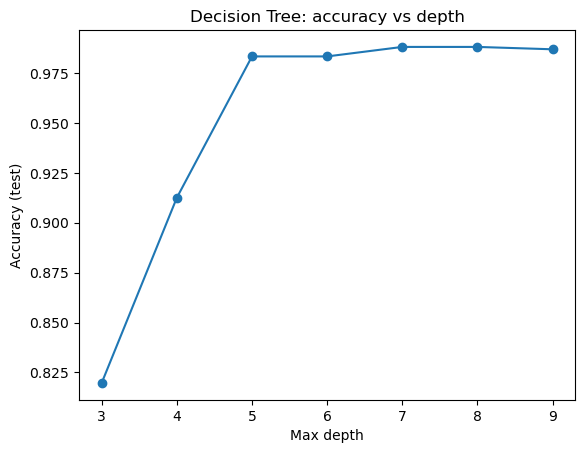

Decision Tree — 95% bootstrap CIs


,mean,std,2.5%,50%,97.5%
accuracy,0.983530,0.003324,0.976205,0.983641,0.989604
f1,0.976930,0.004762,0.965481,0.977229,0.985987
nll,0.100921,0.025884,0.063624,0.096100,0.153641
ece,0.004694,0.002148,0.001322,0.004344,0.009681


In [50]:
# Accuracy vs depth curve
depths = list(range(3,10))
accs = []
for d in depths:
    t = DecisionTreeClassifier(max_depth=d, min_samples_leaf=5, random_state=RANDOM_STATE).fit(X_train, y_train)
    accs.append(accuracy_score(y_test, t.predict(X_test)))

plt.figure()
plt.plot(depths, accs, marker='o')
plt.xlabel('Max depth')
plt.ylabel('Accuracy (test)')
plt.title('Decision Tree: accuracy vs depth')
plt.show()

# 95% bootstrap CIs
ci_tr = bootstrap_ci(y_test.to_numpy(), proba_tr, pred_tr, average=avg, B=300, seed=RANDOM_STATE)
print("Decision Tree — 95% bootstrap CIs"); display(ci_tr)

## C) KNN Classifier

KNN (k=20, distance-weighted) metrics: {'accuracy': 0.9875074360499703, 'f1': 0.9833425574016718, 'nll': 0.029879531457224884, 'ece': 0.00896488731151703}


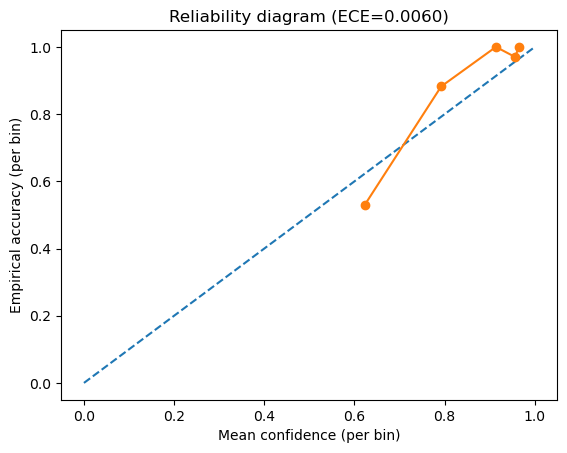

KNN (k=20) — 95% bootstrap CIs


,mean,std,2.5%,50%,97.5%
accuracy,0.987690,0.002718,0.981559,0.988102,0.992861
f1,0.983506,0.003805,0.975230,0.983789,0.990477
nll,0.029570,0.004448,0.021127,0.029582,0.038393
ece,0.011836,0.001694,0.008874,0.011728,0.015516


,class,ece,prevalence
0,upstairs,0.008510,0.100535
1,walking,0.008457,0.248662
2,downstairs,0.006256,0.080904
3,standing,0.005556,0.227246
4,sitting,0.005512,0.252826
5,jogging,0.000203,0.089827


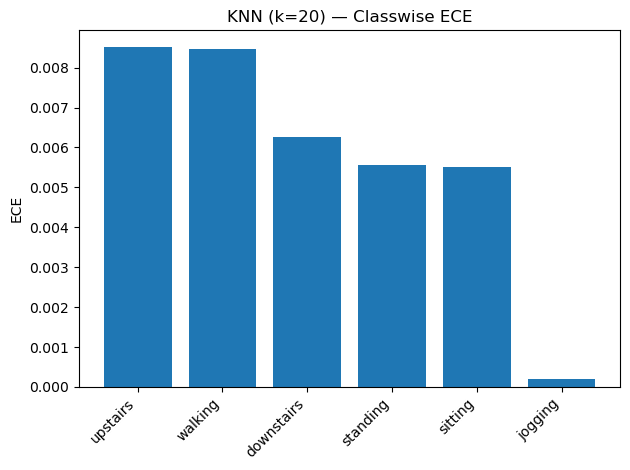

In [54]:
# === KNN classifier (instance-based, distance-weighted) ===
from sklearn.neighbors import KNeighborsClassifier

# Choose k (you can tweak). Distance weighting usually gives better probabilities.
K = 20
knn = KNeighborsClassifier(n_neighbors=K, weights='distance', n_jobs=-1)
knn.fit(Xtr_s, y_train)

proba_knn = knn.predict_proba(Xte_s)
pred_knn  = knn.predict(Xte_s)

avg = 'binary' if len(np.unique(y)) <= 2 else 'macro'

# Metrics (+ aligned labels for NLL)
m_knn = compute_metrics(
    y_test.to_numpy(), proba_knn, pred_knn,
    average=avg, labels=knn.classes_, binning='equal_freq'
)
print(f"KNN (k={K}, distance-weighted) metrics:", m_knn)

# Reliability diagram / ECE
_ = reliability_ece(
    y_test.to_numpy(), proba_knn,
    classes=knn.classes_, y_pred=pred_knn,
    n_bins=50, binning='equal_freq'
)

# 95% bootstrap CIs
ci_knn = bootstrap_ci(
    y_test.to_numpy(), proba_knn, pred_knn,
    average=avg, labels=knn.classes_, B=300, seed=42, binning='equal_freq'
)
print(f"KNN (k={K}) — 95% bootstrap CIs"); display(ci_knn)

# Classwise ECE (which classes are miscalibrated?)
macro_ece_knn, ece_table_knn = classwise_ece(
    y_test.to_numpy(), proba_knn, knn.classes_,
    n_bins=50, binning='equal_freq'
)
# print("KNN classwise macro-ECE:", macro_ece_knn)
display(ece_table_knn)
plot_ece_bar(ece_table_knn, title=f'KNN (k={K}) — Classwise ECE')


In [56]:
# Inspect the top neighbors for interpretability (choose any test index i)
i = 0
dist, idx = knn.kneighbors(Xte_s[i:i+1], n_neighbors=K, return_distance=True)
nbr_idx = idx[0]
nbr = pd.DataFrame({
    'train_idx': nbr_idx,
    'distance': dist[0],
    'neighbor_label': y_train.to_numpy()[nbr_idx]
}).sort_values('distance')
print("Test sample true / predicted:", y_test.iloc[i], pred_knn[i])
display(nbr.head(20))

Test sample true / predicted: upstairs upstairs


,train_idx,distance,neighbor_label
0,1679,0.990505,upstairs
1,2582,1.067001,upstairs
2,4909,1.140394,upstairs
3,5427,1.186283,upstairs
4,4988,1.195694,upstairs
5,4965,1.221714,upstairs
6,228,1.288909,upstairs
7,4191,1.344843,upstairs
8,2898,1.384276,upstairs
9,770,1.419982,upstairs


## D) EBM — Explainable Boosting Machine

In [13]:
!pip install interpret

     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ---------------------------------- ----- 3.4/4.0 MB 16.8 MB/s eta 0:00:01
     ---------------------------------------- 4.0/4.0 MB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   --------------- ------------------------ 6.3/16.6 MB 32.2 MB/s eta 0:00:01
   ---------------------------------------  16.5/16.6 MB 40.0 MB/s eta 0:00:01
   ---------------------------------------- 16.6/16.6 MB 36.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------- ----------------- 4.5/7.8 MB 20.7 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 21.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -----

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier(interactions=0, n_jobs=-1, random_state=RANDOM_STATE)
ebm.fit(X_train, y_train)


In [ ]:
proba_ebm = ebm.predict_proba(X_test)
pred_ebm  = ebm.predict(X_test)

avg = 'binary' if len(np.unique(y))<=2 else 'macro'
m_ebm = compute_metrics(y_test.to_numpy(), proba_ebm, pred_ebm, average=avg)
print("EBM metrics:", m_ebm)
    
# 95% bootstrap CIs
ci_ebm = bootstrap_ci(y_test.to_numpy(), proba_ebm, pred_ebm, average=avg, B=300, seed=RANDOM_STATE)
print("EBM — 95% bootstrap CIs"); display(ci_ebm)

EBM metrics: {'accuracy': 0.9970255800118977, 'f1': 0.9958826071302589, 'nll': 0.013194009718195152, 'ece': 5.744039202680078e-05}
EBM — 95% bootstrap CIs


,mean,std,2.5%,50%,97.5%
accuracy,0.997131,0.001345,0.994051,0.997026,0.999405
f1,0.996019,0.001946,0.991409,0.996153,0.999275
nll,0.012908,0.006192,0.004179,0.011991,0.028100
ece,0.001022,0.000793,0.000061,0.000889,0.002685


In [28]:
from interpret import show
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/2536165228208/ -->

In [29]:
show(ebm.explain_local(X_test[:10], y_test[:10]), 0)

<!-- http://127.0.0.1:7001/2534131853024/ -->

## Model comparison summary (metrics)

In [57]:

rows = []
avg = 'binary' if len(np.unique(y))<=2 else 'macro'
rows.append({'model':'L2-Logistic', **compute_metrics(y_test.to_numpy(), proba_lr, pred_lr, average=avg)})
rows.append({'model':'Decision Tree', **compute_metrics(y_test.to_numpy(), proba_tr, pred_tr, average=avg)})
rows.append({'model':'KNN Classifier', **compute_metrics(y_test.to_numpy(), proba_knn, pred_knn, average=avg)})
rows.append({'model':'EBM', **compute_metrics(y_test.to_numpy(), proba_ebm, pred_ebm, average=avg)})

summary_df = pd.DataFrame(rows)
display(summary_df)


,model,accuracy,f1,nll,ece
0,L2-Logistic,0.992861,0.987988,0.029366,0.008855
1,Decision Tree,0.983343,0.976752,0.102790,0.001725
2,KNN Classifier,0.987507,0.983343,0.029880,0.008965
3,EBM,0.997026,0.995883,0.013194,0.000208



## ✍️ Exercise 

**Goal:** Meet an **interpretability budget** with one intrinsic model and justify the trade-off.

1) Pick a budget:  
   - Logistic: ≤ **n** nonzero coefficients (choose coefficient C [0.1, 1, 10] for L1 penalization).  
   - Decision Tree: depth **3** ≤ d ≤ **7** and min_samples_leaf **3** ≤ m ≤ **7**. 
   - KNN Classifier: choose **k** from a [5, 10, 20].
   - EBM: ≤ **3** max_leaves and **[0, 0.5x, 1x]** interaction.

2) Tune hyperparameters using cross validation to satisfy the budget. Report test **Accuracy**, **F1**, **NLL**, **ECE** and their **95% bootstrap CIs** (use `bootstrap_ci`).

